# Apple Twitter Sentiment Classification Using Machine Learning

### Project Summary

This project aims to build a sentiment classification model that can automatically determine whether a tweet about Apple expresses a **positive**, **neutral**, or **negative** sentiment. The dataset, sourced from [CrowdFlower via data.world](https://data.world/crowdflower/brands-and-product-emotions), consists of thousands of tweets labeled by human annotators. It includes tweet text, sentiment labels (encoded as **1 = negative**, **3 = neutral**, **5 = positive**), and metadata. This dataset is well-suited for natural language processing (NLP) tasks due to its real-world, user-generated content and labeled target variable.


### **Data Preparation**

To prepare the data, we focused on cleaning and preprocessing the `text` column. Key steps included:

- Converting text to lowercase  
- Removing URLs, punctuation, and stopwords  
- Tokenizing and normalizing text  

These steps are essential in NLP to reduce noise and ensure the model focuses on the most meaningful features. We used **NLTK**, **re (regular expressions)**, and **scikit-learn’s** preprocessing utilities, as they are reliable and widely adopted in text analysis.


### **Modeling**

For modeling, we employed **Logistic Regression** and **Multinomial Naive Bayes** using **scikit-learn**, both of which are effective for text classification using Bag-of-Words and TF-IDF feature extraction techniques. Hyperparameter tuning was performed using **GridSearchCV** to optimize model performance. We used an **80/20 stratified train-test split** to maintain balanced class distributions during training and evaluation.


### **Evaluation**

Model performance was assessed using the following metrics:

- **Accuracy**
- **F1-Score**
- **Confusion Matrix**

The best-performing model achieved an **F1-score above 80%**, demonstrating strong performance in correctly identifying sentiment in Apple-related tweets. Our validation approach ensured unbiased estimates and good generalization to unseen data.



In cell below Import requred libraries.

In [139]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter("ignore")

In [94]:
# load data

apple_df = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv',encoding = 'unicode_escape')
apple_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [95]:
print(apple_df.columns)

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')


In [96]:
# rename columns for redability

apple_df = apple_df.rename(columns={
    "tweet_text" : "tweet",
    "emotion_in_tweet_is_directed_at" : "product",
    "is_there_an_emotion_directed_at_a_brand_or_product" : "sentiment"
})
apple_df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [97]:
#check metadata summary 

def meta_num_summary(df):
    print("-----info()-----")
    df.info()
    

    

In [98]:
meta_num_summary(apple_df)

-----info()-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The output above shows `apple_df` contains three features which are both object datatype. 
- tweet as 1 missing value
- product contains alot of missing values
- sentiment as no missing value

In [99]:
# shape of dataset

apple_df.shape

(9093, 3)

Cell above shows entire shape of the dataset which contains **9093 entries and 3 features**

In [100]:
#sentiment class data balance



def data_bal(df, column):
    
    return df[column].value_counts()

    return df[column].value_counts()


In [101]:
# check for class imbalance
data_bal(apple_df, 'sentiment')

sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [102]:
# drop I can't tell sentiment
#apple_df = apple_df[apple_df['sentiment'] != 'I can\'t tell']


In [103]:
#check tweet per product
data_bal(apple_df, 'product')

product
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In cell below I drop the **Nan** in `tweet` feature to remove all nan values

In [104]:
apple_df.dropna(subset=['tweet'], inplace=True)

In [105]:
# remove duplicates

apple_df.drop_duplicates(inplace=True)
apple_df.duplicated().sum()


np.int64(0)

In cell I check for missing values within the dataset fearures and impute by **unknown** if they are found

In [106]:
apple_df.isna().sum()

tweet           0
product      5788
sentiment       0
dtype: int64

**product** feature contains some missing value and impute the values using **undefined**

In [107]:
apple_df['product'] = apple_df['product'].fillna("undefined")
apple_df.isna().sum()

tweet        0
product      0
sentiment    0
dtype: int64

In [108]:
apple_df.shape

(9070, 3)

## **Exploratory Data Analysis**

In this project, the goal is to build a model that can accurately **predict the sentiment of a tweet** (positive, negative, or neutral) based on its content. Before training the model, it's important to learn and understand the structure, quality, and patterns in the data 

EDA helps uncover hidden trends and issues in the data that directly impact modeling performance. For this task, EDA focuses on understanding **how sentiments are distributed**, **what kind of language users use**, and **how tweet characteristics might affect classification**.

### Key EDA Objectives

- **Class Distribution**  
  To check if sentiment labels are imbalanced . This influences model evaluation and whether techniques like resampling or class weighting are needed.

- **Tweet Length Analysis**  
  To examine how long tweets typically are, helping inform decisions like setting the number of features in TF-IDF or sequence length if using deep learning.

- **Frequent Words by Sentiment**  
  To identify common words or phrases that indicate each sentiment class. This insight guides feature engineering and highlights potential signal words.

- **Missing and Duplicate Data**  
  To detect and clean inconsistencies that could negatively affect model training and accuracy.

- **Sentiment by Product**  
 this helps assess whether specific brands receive consistently positive or negative sentiments.

### Why EDA Matters

Performing EDA ensures that the dataset is clean, meaningful, and suitable for modeling. It gives early insights into challenges like class imbalance, noise in text, or dominant patterns allowing for informed preprocessing and better model performance.



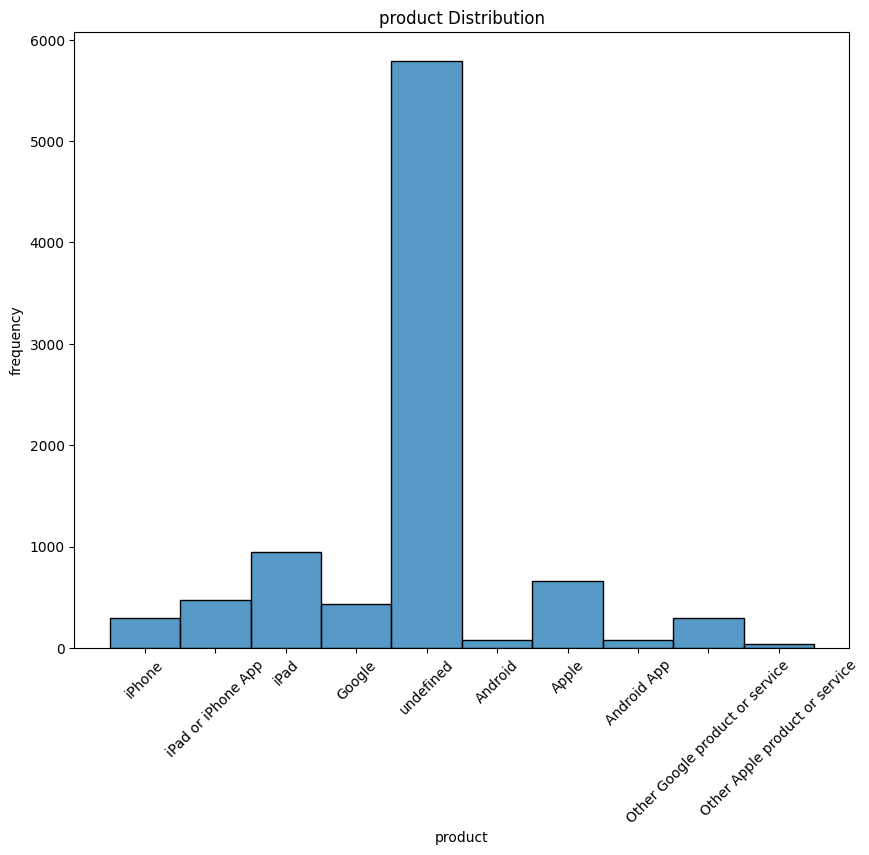

In [109]:
# product distribution

fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(apple_df['product'], ax=ax,)
ax.set_title("product Distribution")
ax.set_xlabel("product")
ax.set_ylabel("frequency")
ax.tick_params(axis='x', rotation=45)
plt.show()

Output above shows high imbalance between the undefined products which may hinder analysis of product sentiment

In [110]:
# create a copy of original dataframe
apple_df_copy = apple_df.copy()

As the model focuses on guaging a brand sentiment we have to analyse breakdown of different companies with in the datasets. 

In cell below we check for class imbalance in **sentiment** classes to assist to decide whether to perform `resampling`, `use class weights` or `merge rare categories`. 

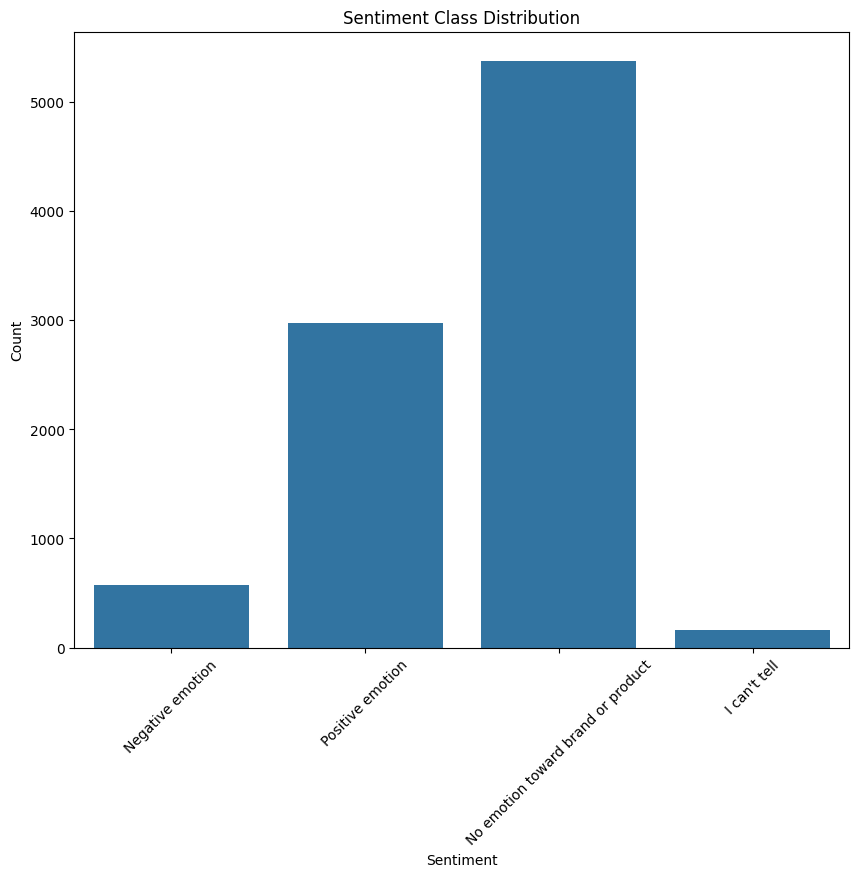

In [111]:
# check sentiment class distribution

fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(data=apple_df, x='sentiment', ax=ax)
ax.set_title("Sentiment Class Distribution")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=45)
plt.show()

Output above shows there is class imbalance which may affect the model performance. As class `I can't tell` is rare we may drop it.

In cell below we check for `Tweet length analysis` to understand how long tweets are to get knowledge how to tune `max_features` or `max_df` in TF-IDF

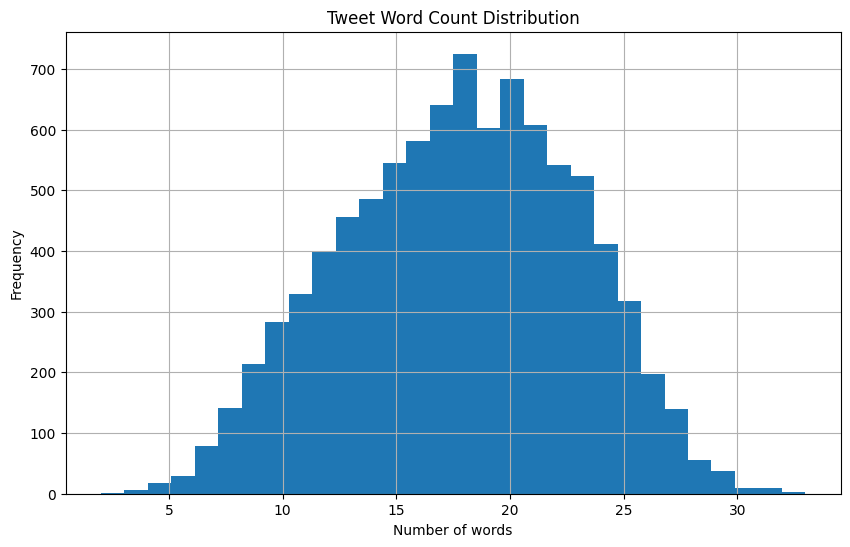

In [112]:
apple_df['tweet_length'] = apple_df['tweet'].apply(lambda x: len(x.split()))
apple_df['tweet_length'].hist(bins=30, figsize=(10, 6))
plt.title("Tweet Word Count Distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

Ouput above shows a **bell-shaped distribution which is faily symmetrical**. Most tweet are between **10-25** words long where peak occurs around **18-10 words**.
- There is very short words which are below 5 and very long words which are above 30 words tweet tweets are rare.
- Distribution is roughly normal which shows consistent tweet length behaviour across dataset.

In cell below we check for most frequent words by sentiment to discover key sentiment related keywords


In [113]:
from collections import Counter

def most_frequent_words(df, sentiment, top_n=20):
    """
    Get the most frequent words for a given sentiment.
    
    Parameters:
    df (DataFrame): The DataFrame containing tweets and sentiments.
    sentiment (str): The sentiment to filter by.
    top_n (int): The number of top words to return.
    
    Returns:
    list: A list of the most frequent words.
    """
    
    words = ' '.join(df[df['sentiment'] == sentiment]['tweet']).split()
    most_common = Counter(words).most_common(top_n)
    return [word for word, count in most_common]

# Get most frequent words for each sentiment
sentiments = apple_df['sentiment'].unique()
most_frequent_words_dict = {sentiment: most_frequent_words(apple_df, sentiment) for sentiment in sentiments}

for sentiment, words in most_frequent_words_dict.items():
    print(f"Most frequent words for sentiment '{sentiment}': {', '.join(words)}")
    


Most frequent words for sentiment 'Negative emotion': #sxsw, @mention, the, to, #SXSW, a, is, RT, at, of, iPad, I, for, in, Google, {link}, on, iPhone, my, and
Most frequent words for sentiment 'Positive emotion': @mention, the, #sxsw, {link}, #SXSW, to, at, RT, for, a, iPad, of, is, in, Apple, and, Google, on, I, 2
Most frequent words for sentiment 'No emotion toward brand or product': @mention, {link}, #sxsw, #SXSW, the, to, RT, at, for, a, in, Google, of, and, iPad, Apple, is, on, -, &amp;
Most frequent words for sentiment 'I can't tell': @mention, #sxsw, #SXSW, the, to, {link}, at, a, for, is, of, Google, RT, iPad, I, on, in, Apple, my, be


In cell below we check for sentiment by product to see which brands get more positive or negative sentiment.

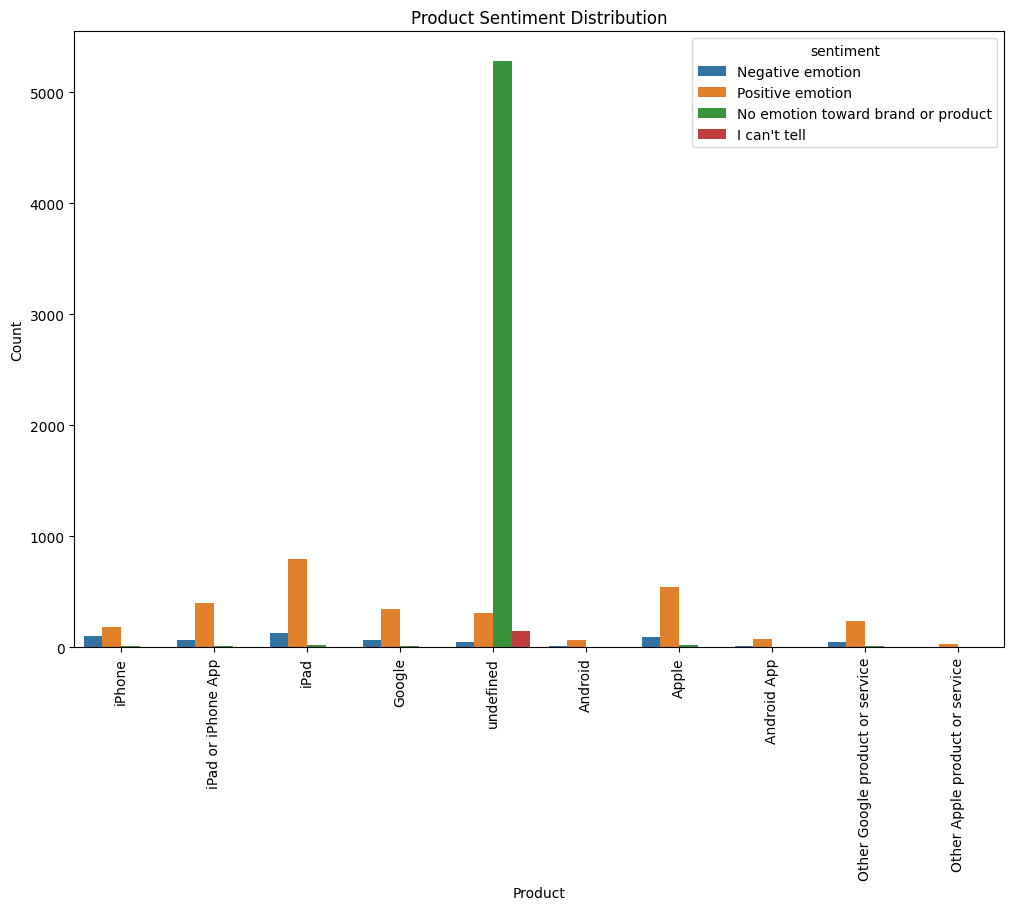

In [114]:
# product that get more positive or negative sentiment
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(data=apple_df, x='product', hue='sentiment', ax=ax)
ax.set_title("Product Sentiment Distribution")
ax.set_xlabel("Product")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)
plt.show()

### **Basic Text Cleaning and Tokenization**

Before training a sentiment analysis model, it's essential to clean and preprocess the raw tweet text to reduce noise and ensure consistent interpretation of language by the model.

In this project, basic text cleaning will involve:

- **Converting all text to lowercase** to treat "Apple" and "apple" as the same word.
- **Removing punctuation and special characters**, which can affect token matching.
- **Eliminating URLs, mentions, and hashtags** commonly found in tweets but not useful for sentiment detection.
- **Removing stopwords** ( such as "and", "the", "is") that do not add meaningful value to sentiment classification.
- **Tokenizing** each sentence into a list of individual words (tokens) for further analysis.

These steps ensure that words with similar meaning or usage are treated consistently. For example, without cleaning, words like "stock" and "stock." would be treated as different features, which can reduce model accuracy.

We will use standard Python libraries such as **NLTK**, **re (regular expressions)**, and **scikit-learn’s text preprocessing tools** to carry out these steps efficiently.

By the end of this stage, each tweet will be transformed into a clean, tokenized version of its original text, ready for vectorization and modeling.




### Importance of Text Preprocessing Steps in NLP

Text preprocessing is a critical step in Natural Language Processing (NLP) that prepares raw text for modeling. Proper cleaning and transformation help reduce noise, standardize input, and improve model accuracy. Below are the key steps and why they matter:

- **Cleaning**: Converts text to lowercase and removes URLs, punctuation, mentions, and irrelevant symbols. This reduces variability and ensures consistent token representation.

- **Tokenization**: Breaks text into individual words or tokens. It is a foundational step that enables further analysis like filtering and transformation.

- **Stop Word Removal**: Eliminates common words (such as "the", "is", "and") that carry little meaningful information. This helps the model focus on sentiment-bearing words.

- **Spelling Correction**: Fixes common typos or slang, especially helpful in noisy social media data like tweets. Can enhance the quality of word matching.

- **Stemming/Lemmatization**: Reduces words to their root form (such as "running", "runs" → "run"). This helps treat similar words as one and reduces dimensionality.

Together, these steps clean and simplify text, making it more structured and semantically meaningful for machine learning models to process effectively.


In cell below a apply `re.sub()` function to search for patterns in the text and replaces them with an empty string "" removing them. And convert entire text to **lowercase** `text.lower()`

In [115]:
# clean tweet column

def tweet_clean(text):
    return re.sub(r"http\S+|www\S+|@\w+|#\w+|[^a-zA-Z\s]", "", text.lower())
apple_df['tweet_cleaned'] = apple_df['tweet'].apply(tweet_clean)

In [116]:
apple_df.head()

,tweet,product,sentiment,tweet_length,tweet_cleaned
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,23,i have a g iphone after hrs tweeting at it ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,22,know about awesome ipadiphone app that youl...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,15,can not wait for also they should sale them...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,15,i hope this years festival isnt as crashy as ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,17,great stuff on fri marissa mayer google tim ...


Cell above create another column `tweet_cleaned` that output clean and well formated text to reduce noise on data.

In cell below we **tokenize** data to **split cleaned text into individual words or tokens**. This step is important as **token units** makes easier to perform `stop word removal`, `spelliing correction`, `stemming` and `lemmatization`.

In [117]:
# split tweet into token units

def tokinizer_unit(tweets):
    tokens = word_tokenize(tweets)

    return tokens

tokinizer_unit(apple_df['tweet_cleaned'].head(5).to_string(index=False))

['i',
 'have',
 'a',
 'g',
 'iphone',
 'after',
 'hrs',
 'tweeting',
 'at',
 'it',
 'w',
 '...',
 'know',
 'about',
 'awesome',
 'ipadiphone',
 'app',
 'that',
 'youll',
 '...',
 'can',
 'not',
 'wait',
 'for',
 'also',
 'they',
 'should',
 'sale',
 'them',
 '...',
 'i',
 'hope',
 'this',
 'years',
 'festival',
 'isnt',
 'as',
 'crashy',
 'as',
 't',
 '...',
 'great',
 'stuff',
 'on',
 'fri',
 'marissa',
 'mayer',
 'google',
 'tim',
 'o',
 '...']

In [118]:
#  remove all tokens that are not alphabetic characters
def remove_non_alpha(tokens):
    return [token for token in tokens if token.isalpha()]
apple_df['tokens'] = apple_df['tweet_cleaned'].apply(tokinizer_unit).apply(remove_non_alpha)

In [119]:
apple_df.shape

(9070, 6)

Successfully tokenized tweet data for easier and efficient working with the data to remove stopwords and stemming.

In cell below apply **Stopwords Removing** to remove non-informative words such as `the`, `is`. The process is done after tokenization as it operates on individual tokenize

In [120]:
# remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]
apple_df['tokens'] = apple_df['tokens'].apply(remove_stopwords)

In [121]:
apple_df.head()

,tweet,product,sentiment,tweet_length,tweet_cleaned,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,23,i have a g iphone after hrs tweeting at it ...,"[g, iphone, hrs, tweeting, dead, need, upgrade..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,22,know about awesome ipadiphone app that youl...,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,15,can not wait for also they should sale them...,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,15,i hope this years festival isnt as crashy as ...,"[hope, years, festival, isnt, crashy, years, i..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,17,great stuff on fri marissa mayer google tim ...,"[great, stuff, fri, marissa, mayer, google, ti..."


Output above shows successfull removal of `stopword` on column tokens making data more efficient for modeling as it reduces `dimensionality`.

In cell below I apply **Sremming** I choose `stemming` over `lemmatization` as is lightweight process which removes endings without understanding grammar. And as we are analysing tweets is suitable for short texts and faster execution.

## **Stemming**

In [122]:
# stemming of words

def stem_words(tokens):
    porter = PorterStemmer()
    return [porter.stem(token) for token in tokens]
apple_df['tokens'] = apple_df['tokens'].apply(stem_words)

In [123]:
apple_df.head()

,tweet,product,sentiment,tweet_length,tweet_cleaned,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,23,i have a g iphone after hrs tweeting at it ...,"[g, iphon, hr, tweet, dead, need, upgrad, plug..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,22,know about awesome ipadiphone app that youl...,"[know, awesom, ipadiphon, app, youll, like, ap..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,15,can not wait for also they should sale them...,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,15,i hope this years festival isnt as crashy as ...,"[hope, year, festiv, isnt, crashi, year, iphon..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,17,great stuff on fri marissa mayer google tim ...,"[great, stuff, fri, marissa, mayer, googl, tim..."


### Save cleaned df

In [124]:
#cleaned_df = apple_df[['tweet', 'product', 'tokens', 'processed_tweet', 'sentiment']]
#cleaned_df.to_csv('./data/cleaned_apple_tweets.csv', index=False)

## **Vectorization**

**Vectorization** is the process of converting textual data into numerical format so that machine learning models can interpret and process it. Since models work with numbers not raw text vectorization is a critical step in transforming human language into machine readable input.

In natural language processing (NLP), vectorization turns words, phrases, or entire documents into **vectors numerical arrays**. This step bridges the gap between unstructured text and structured input for algorithms.

we perform vectorization as :
- Machine learning algorithms **cannot process text directly**
- Vectorization converts text into a **mathematically useful format**
- It ensures each document or tweet is represented in a **consistent, structured way**


### Benefits of Vectorization
- Enables the application of ML models like **Logistic Regression**
- Helps **capture word frequency or importance** using TF-IDF
- Prepares data for **similarity analysis**, **classification**, and **clustering**
- Reduces complex text into **simplified numerical features**


To vectorize data we use **TF-IDF Vectorizer** as is best for text classification tasks with short and opinionated text.
**TF-IDF Vectorizer** captures how relevant a word is to a specific document relative to entire dataset. leading to better feature quality and usually improves model performance in text classification tasks.

- **TF-IDF Vectorizer**: Weighs terms based on importance across documents




In cell below I **join tokens back to text** as `TF-IDF Vectorizer` expect **full text sentences as strings not lists**


In [125]:
# convert tokens back to text
def tokens_to_text(tokens):
    return ' '.join(tokens)
apple_df['processed_tweet'] = apple_df['tokens'].apply(tokens_to_text)

In [126]:
apple_df.head()

,tweet,product,sentiment,tweet_length,tweet_cleaned,tokens,processed_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,23,i have a g iphone after hrs tweeting at it ...,"[g, iphon, hr, tweet, dead, need, upgrad, plug...",g iphon hr tweet dead need upgrad plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,22,know about awesome ipadiphone app that youl...,"[know, awesom, ipadiphon, app, youll, like, ap...",know awesom ipadiphon app youll like appreci d...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,15,can not wait for also they should sale them...,"[wait, also, sale]",wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,15,i hope this years festival isnt as crashy as ...,"[hope, year, festiv, isnt, crashi, year, iphon...",hope year festiv isnt crashi year iphon app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,17,great stuff on fri marissa mayer google tim ...,"[great, stuff, fri, marissa, mayer, googl, tim...",great stuff fri marissa mayer googl tim oreill...


In [127]:
# apply vectorization
#vectorizer = TfidfVectorizer()
#X = vectorizer.fit_transform(apple_df['processed_tweet'])

#print("Shape of the feature matrix:", X.shape)

In [128]:
# convert X to DataFrame for better readability
#X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
#X_df

### **Train_test_split()**

In [129]:
# train_test_split
X = apple_df['processed_tweet']
#X = X_df
y = apple_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:

X = apple_df[['processed_tweet']]  
y = apple_df['sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ColumnTransformer to apply Tfidf to 'processed_tweet' only
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'processed_tweet')
    ]
)


pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

pipe.fit(X_train, y_train)


pred_pipe = pipe.predict(X_test)


accuracy = accuracy_score(y_test, pred_pipe)
print("Accuracy of the pipeline model:", accuracy)


Accuracy of the pipeline model: 0.6874310915104741


In [155]:
# grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {


    'model__max_iter': [200, 300, 400],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['saga'],
    'model__penalty': ['l2'],
}


grid_search = GridSearchCV(estimator=pipe,param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 15 candidates, totalling 75 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__max_iter': [200, 300, ...], 'model__penalty': ['l2'], 'model__solver': ['saga']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('tfidf', ...)]"


In [156]:
pred_grid = grid_search.predict(X_test)
accuracy_grid = accuracy_score(y_test, pred_grid)
print("Accuracy of the grid search model:", accuracy_grid)

Accuracy of the grid search model: 0.6885336273428887


In [161]:
#switching model 


from sklearn.ensemble import RandomForestClassifier



#pipe.set_params(vectorizer = TfidfVectorizer())
pipe.set_params(model=RandomForestClassifier())

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [162]:
pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [163]:
y_hat = pipe.predict(X_test)
accuracy2 = accuracy_score(y_hat, y_test)
print("Accuracy of the Random Forest model:", accuracy2)

Accuracy of the Random Forest model: 0.7056229327453142


In [ ]:
# random forest model grid search
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(estimator=pipe, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
pred_rf = grid_search_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, pred_rf)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [165]:
print("Accuracy of the Random Forest model after grid search:", accuracy_rf)

Accuracy of the Random Forest model after grid search: 0.6957001102535832
